In [1]:
import wave
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load sound
if __name__ == '__main__':
    wav_file = 'data/wav/BASIC5000_0001.wav'
    with wave.open(wav_file) as wav:
        sampling_rate = wav.getframerate()
        sample_size = wav.getsampwidth()
        num_channels = wav.getnchannels()
        num_samples = wav.getnframes()

        wave_form = wav.readframes(num_samples)
        wave_form = np.frombuffer(wave_form, dtype=np.int16)
print(f"sampling rate: {sampling_rate}")
print(f"sample size: {sample_size} Byte")
print(f"num channels: {num_channels}")
print(f"num samples: {num_samples}")


sampling rate: 16000
sample size: 2 Byte
num channels: 1
num samples: 51040


/Users/shibu/.local/share/virtualenvs/python_asr-1yhvh1AF/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


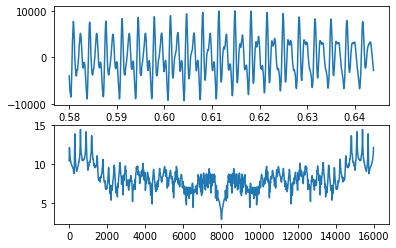

In [3]:
# FFT
target_time = 0.58
target_index = np.int(target_time * sampling_rate)
## FFT対象のサンプル数
fft_size = 1024
target_frame = wave_form[target_index: target_index+fft_size]
spectrum = np.fft.fft(target_frame)
absolute = np.abs(spectrum)
log_absolute = np.log(absolute+1e-7)

fig = plt.figure()
ax1 = fig.add_subplot(211)
time_axis = np.arange(num_samples) / sampling_rate
ax1.plot(time_axis[target_index: target_index+fft_size], wave_form[target_index: target_index+fft_size])
ax2 = fig.add_subplot(212)
freq_axis = np.arange(fft_size) * sampling_rate / fft_size
ax2.plot(freq_axis, log_absolute)

num_frames: 317


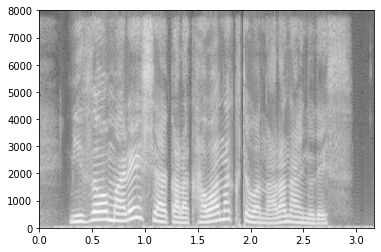

In [4]:
# 短時間フーリエ変換
# (mili sec -> num samples)
frame_size = int(25 * 0.001 * sampling_rate)
frame_shift = int(10 * 0.001 * sampling_rate)
## fftのサンプル数はフレームサイズより大きく、2のべき乗
fft_size = 1
while frame_size > fft_size:
    fft_size *= 2
## 合計のフレーム数
num_frames = (num_samples - frame_size) // frame_shift + 1
print(f"num_frames: {num_frames}")
## スペクトログラム行列（各フレームにおける各周波数成分の振幅スペクトルを表す）
spectrogram = np.zeros((num_frames, int(fft_size /2) + 1))

for frame_idx in range(num_frames):
    start_idx = frame_idx * frame_shift
    frame = wave_form[start_idx: start_idx + frame_size].copy()
    ## 窓処理
    frame = frame * np.hamming(frame_size)
    ## 2のべき乗のサンプル数としてFFTするためにn=fft_sizeとする
    spectrum = np.fft.fft(frame, n=fft_size)
    absolute = np.abs(spectrum)
    absolute = absolute[0:int(fft_size /2)+1]
    log_absolute = np.log(absolute + 1e-7)
    spectrogram[frame_idx,:] = log_absolute

## このままでは横軸は各フレーム番号
plt.imshow(np.flipud(spectrogram.T))
##　フレーム番号を時間スケールに変換したい
plt.imshow(np.flipud(spectrogram.T), extent=[0, frame_shift / sampling_rate * num_frames, 0, sampling_rate / 2], aspect='auto', cmap='gray')







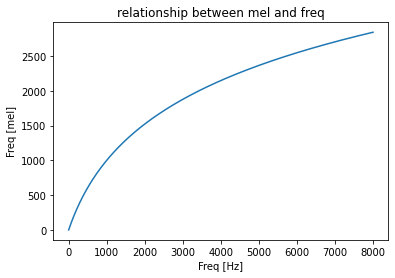

In [6]:
# メル尺度と周波数の関係
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(0,8000)
y = 1127 * np.log(x / 700 + 1)
ax.plot(x,y)
ax.set_title("relationship between mel and freq", loc="center",)
ax.set_xlabel("Freq [Hz]")
ax.set_ylabel("Freq [mel]")
fig.savefig("figures/0.png")

/Users/shibu/.local/share/virtualenvs/python_asr-1yhvh1AF/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/shibu/.local/share/virtualenvs/python_asr-1yhvh1AF/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


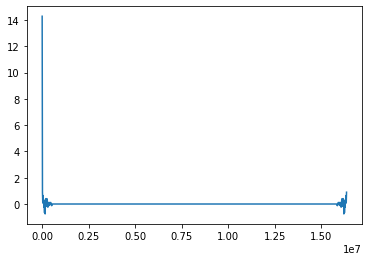

In [11]:
# ケプストラム分析
target_time = 0.58
target_index = np.int(target_time * sampling_rate)
fft_size = 1024
frame = wave_form[target_index: target_index + fft_size].copy()
# フレーム両端の違いによるノイズを防ぐための時間領域での切り出しなので時間領域でフィルタを「かける
frame = frame * np.hamming(fft_size)
# パワースペクトルの計算
spectrum = np.fft.fft(frame)
log_power_spectrum = 2 * np.log(np.abs(spectrum) + 1e-7)
# ケプストラムの計算
cepstrum = np.fft.ifft(log_power_spectrum)
# 離散的に得られるケプストラムに対してどのインデックスまでを声道特性とみなすか
cep_threshould = 33
# 高域カットする（左右対称であることに注意）
cepstrum_low = cepstrum.copy()
cepstrum_low[cep_threshould+1:-cep_threshould] = 0.0
# ケフレンシ軸の作成
cefr_axis = np.arange(fft_size) * sampling_rate
plt.plot(cefr_axis, cepstrum_low)
# 再度フーリエ変換し、パワースペクトルに戻す
low_power_ceplo = np.abs(np.fft.fft(cepstrum_low))



In [12]:
# MFCCの作成
## MFCCの次元数
num_mel_ceps = 13
## メルフィルタバンクの次元数
num_mel_bins = 23
## DCT-IIの基底関数行列
dct_matrix = np.zeros((num_mel_ceps, num_mel_bins))
for k in range(num_mel_ceps):
    if k == 0:
        dct_matrix[k] = np.ones(num_mel_bins) * np.sqrt(1.0 / num_mel_bins)
    else:
        dct_matrix[k] = np.sqrt(2.0 / num_mel_bins) * np.cos((2. * np.arange(num_mel_bins) + 1.) * k * np.pi / (2. * num_mel_bins))  


(14.286458699136912+0j)

In [ ]:
from 